In [1]:
%%capture
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext training_rl
%set_random_seed 12

In [2]:
%presentation_style

In [3]:
%load_latex_macros


$\newcommand{\vect}[1]{{\mathbf{\boldsymbol{#1}} }}$
$\newcommand{\amax}{{\text{argmax}}}$
$\newcommand{\P}{{\mathbb{P}}}$
$\newcommand{\E}{{\mathbb{E}}}$
$\newcommand{\R}{{\mathbb{R}}}$
$\newcommand{\Z}{{\mathbb{Z}}}$
$\newcommand{\N}{{\mathbb{N}}}$
$\newcommand{\C}{{\mathbb{C}}}$
$\newcommand{\abs}[1]{{ \left| #1 \right| }}$
$\newcommand{\simpl}[1]{{\Delta^{#1} }}$


In [4]:
%autoreload

In [5]:
import os
import warnings

import gymnasium as gym
import torch

from training_rl.offline_rl.behavior_policies.behavior_policy_registry import \
    BehaviorPolicyType
from training_rl.offline_rl.custom_envs.custom_2d_grid_env.obstacles_2D_grid_register import \
    ObstacleTypes
from training_rl.offline_rl.custom_envs.custom_envs_registration import (
    CustomEnv, RenderMode, register_grid_envs)
from training_rl.offline_rl.custom_envs.utils import (
    Grid2DInitialConfig, InitialConfigCustom2DGridEnvWrapper)
from training_rl.offline_rl.generate_custom_minari_datasets.generate_minari_dataset_grid_envs import \
    create_combined_minari_dataset 
from training_rl.offline_rl.generate_custom_minari_datasets.utils import generate_compatible_minari_dataset_name
from training_rl.offline_rl.load_env_variables import load_env_variables
from training_rl.offline_rl.offline_policies.offpolicy_rendering import \
    offpolicy_rendering
from training_rl.offline_rl.offline_policies.policy_registry import PolicyName
from training_rl.offline_rl.offline_trainings.offline_training import \
    offline_training
from training_rl.offline_rl.offline_trainings.policy_config_data_class import (
    TrainedPolicyConfig, get_trained_policy_path)
from training_rl.offline_rl.offline_trainings.restore_policy_model import \
    restore_trained_offline_policy
from training_rl.offline_rl.utils import load_buffer_minari, widget_list
from training_rl.offline_rl.visualizations.utils import snapshot_env
from training_rl.offline_rl.visualizations.utils import (
    get_state_action_data_and_policy_grid_distributions, snapshot_env)
from training_rl.offline_rl.utils import (compare_state_action_histograms,
                                          load_buffer_minari,
                                          state_action_histogram)


load_env_variables()

warnings.filterwarnings("ignore")
register_grid_envs()
render_mode = RenderMode.RGB_ARRAY_LIST if os.environ.get("DISPLAY") else None

<img src="_static/images/aai-institute-cover.svg" alt="Snow" style="width:100%;">
<div class="md-slide title"> Offline RL algorithms exercises </div>

# Offline RL algorithms exercises

Before we saw that off-policy methods cannot learn from data efficiently unless a fair amount of data covering a large part of your environmnet states is available. Only in that case the agent is able to explore the environment and get feedback similarly as you will do in on-line approach. However, this is a rare situation and, as we discussed before, hard to fullfil in realistic application and this is one of the reason we would like to use offline RL were just a small amount of data is available.

We also saw that one of the major issues when you apply off-policy methods to collected data is the tendency of the agent to go o.o.d. and more importantly its imposibility to get back to the in-distribution region, as once it goes o.o.d. the policy behaves unpredictable and this error propagates in the policy evaluation process (i.e. the dynamic programming equations) and the algorithm is not able to learn anything. 


## Exercise I

**Similarly as we did in the offpolicy notebook (nb_95) we will collect a few amount of expert data and a larger amount of suboptimal data .... and we will see how the two offline rl algorithms introduce before, BCQ and CQL, are able to recover the expert policy without going o.o.d. We will compare our results with the imitation learning approach, in particular with the BC algorithm, that as we saw in the imitation learning section (nb_93) is another valid option, as far as you have expert data.**


In this exercise we will collect two datasets with expert and suboptimal data that tries to bring the agent from (3,0) to (0,7) .


ToDo --> CHANGE THIS IMAGE !!!
<img src="_static/images/nb_95_env_image_1.png" alt="grid environment configuration" style="height:400px;">

I  - **Suboptimal expert policy**:  collect ~ 2000 steps

II - **expert policy**: collect ~ 500 steps

### Behavioral Policies and Minari DataSet configurations

**Create the environment:**

In [114]:
ENV_NAME = CustomEnv.Grid_2D_8x8_discrete

# Grid configuration
OBSTACLE = ObstacleTypes.obstacle_8x8_top_right
INITIAL_STATE = (3, 0)
FINAL_STATE = (0, 7)

env_2D_grid_initial_config = Grid2DInitialConfig(
    obstacles=OBSTACLE,
    initial_state=INITIAL_STATE,
    target_state=FINAL_STATE,
)

env = InitialConfigCustom2DGridEnvWrapper(gym.make(ENV_NAME, render_mode=render_mode), env_config=env_2D_grid_initial_config)
#snapshot_env(env)

**Configure behavior policies**

In [145]:
BEHAVIOR_POLICY_I = BehaviorPolicyType.behavior_8x8_suboptimal_rnd_initial_3_0_final_3_7
DATA_SET_IDENTIFIER_I = "_suboptimal_for_offline_rl"
NUM_STEPS_I = 500

BEHAVIOR_POLICY_II = BehaviorPolicyType.behavior_8x8_suboptimal_determ_initial_3_0_final_3_7
DATA_SET_IDENTIFIER_II = "_expert_for_offline_rl"
NUM_STEPS_II = 500

In [180]:
policy_selected = widget_list([BEHAVIOR_POLICY_I, BEHAVIOR_POLICY_II])

Dropdown(options=(<BehaviorPolicyType.behavior_8x8_moves_downwards_within_strip: 'behavior_8x8_moves_downwards…

In [182]:
offpolicy_rendering(
    env_or_env_name=ENV_NAME,
    render_mode=render_mode,
    behavior_policy_name=policy_selected.value,
    env_2d_grid_initial_config=env_2D_grid_initial_config,
    num_frames=1000,
)

SystemExit: 

**Collect data**

In [147]:
config_combined_data = create_combined_minari_dataset(
        env_name=ENV_NAME,
        dataset_identifiers = (DATA_SET_IDENTIFIER_I, DATA_SET_IDENTIFIER_II),
        num_collected_points = (NUM_STEPS_I, NUM_STEPS_II),
        behavior_policy_names = (BEHAVIOR_POLICY_I, BEHAVIOR_POLICY_II),
        combined_dataset_identifier = "combined_data_sets_offline_rl",
        env_2d_grid_initial_config = env_2D_grid_initial_config,
)

dataset_availables = [config_combined_data.data_set_name] + config_combined_data.children_dataset_names
selected_data_set = widget_list(dataset_availables)

Dataset Grid_2D_8x8_discrete-data_obstacle_8x8_top_right_start_3_0_target_0_7_suboptimal_for_offline_rl-v0 deleted!
Dataset Grid_2D_8x8_discrete-data_obstacle_8x8_top_right_start_3_0_target_0_7_expert_for_offline_rl-v0 deleted!
Dataset Grid_2D_8x8_discrete-combined_data_sets_offline_rl-v0 deleted!
Number of episodes in dataset I:9, in dataset II:9 and  in the combined dataset: 18


Dropdown(options=('Grid_2D_8x8_discrete-combined_data_sets_offline_rl-v0', 'Grid_2D_8x8_discrete-data_obstacle…

Dataset /home/ivan/Documents/GIT_PROJECTS/tfl-training-rl/src/training_rl/offline_rl/data/offline_data/Grid_2D_8x8_discrete-combined_data_sets_offline_rl-v0 downloaded. number of episodes: 18


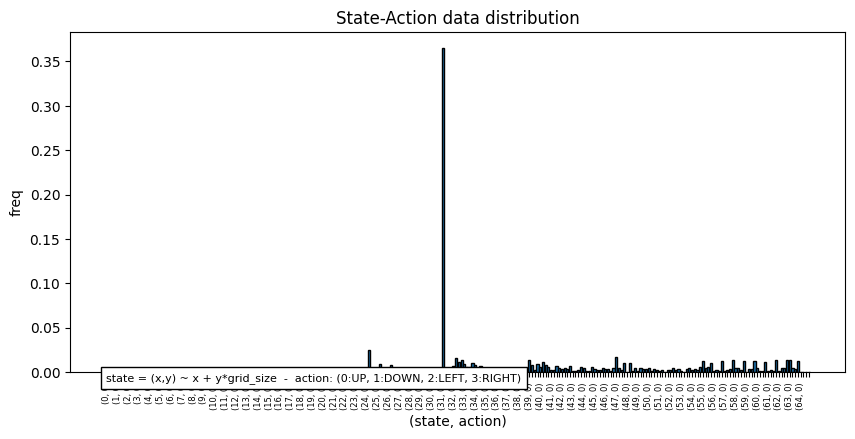

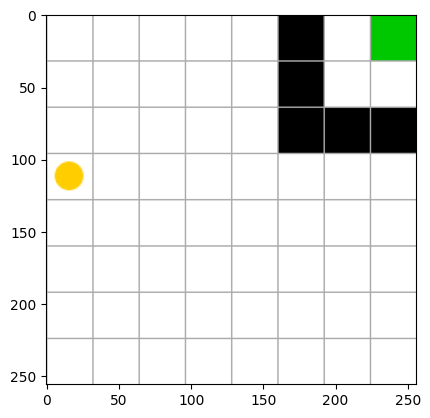

In [148]:
buffer_data = load_buffer_minari(selected_data_set.value)
len_buffer = len(buffer_data)

# Compute state-action data distribution
state_action_count_data, _ = get_state_action_data_and_policy_grid_distributions(buffer_data, env)
state_action_histogram(state_action_count_data, title="State-Action data distribution", inset_pos_xy=(-0.1, -0.01))

snapshot_env(env)

### Training and analysis of results

In this part of the exercise you need to: 

a) Restore the policy configurations (through TrainedPolicyConfig) for three offline RL policies, namely **BCQ, CQL and BC**, i.e.:

offline_policy_config = TrainedPolicyConfig( ... )

Give a look to the policy parameteres in offline_rl/offline_policies. 


b) Train the policies on the **expert data**:

NUM_EPOCHS =10

BATCH_SIZE = 128

STEP_PER_EPOCH = len_buffer


offline_training( ... )


c) Visualize the policies:

offpolicy_rendering( ... )


**SOLUTION:**

In [129]:
offline_rl_policies = [PolicyName.bcq_discrete, PolicyName.cql_discrete, PolicyName.imitation_learning]
selected_offline_rl_policy = widget_list(offline_rl_policies)

Dropdown(options=(<PolicyName.bcq_discrete: 'bcq_discrete'>, <PolicyName.cql_discrete: 'cql_discrete'>, <Polic…

In [155]:
# Offiline - Training

NUM_EPOCHS =10
BATCH_SIZE = 128
STEP_PER_EPOCH = 1.0*len_buffer
NUMBER_TEST_ENVS = 1


offline_policy_config = TrainedPolicyConfig(
    name_expert_data=selected_data_set.value,
    policy_name=selected_offline_rl_policy.value,
    render_mode=render_mode,
    device="cuda"
)

#offline_policy_config.policy_config["unlikely_action_threshold"]=0.6
#offline_policy_config.policy_config["min_q_weight"]=15.0
#offline_policy_config.policy_config["num_quantiles"]=5

offline_training(
    offline_policy_config=offline_policy_config,
    num_epochs = NUM_EPOCHS,
    number_test_envs=NUMBER_TEST_ENVS,
    step_per_epoch=STEP_PER_EPOCH,
    restore_training=False,
)

Dataset /home/ivan/Documents/GIT_PROJECTS/tfl-training-rl/src/training_rl/offline_rl/data/offline_data/Grid_2D_8x8_discrete-combined_data_sets_offline_rl-v0 downloaded. number of episodes: 18


Epoch #1: 1001it [00:01, 864.72it/s, gradient_step=1000, loss=1.046]                                                                                                                                        


Epoch #1: test_reward: -48.150992 ± 0.000000, best_reward: -48.150992 ± 0.000000 in #1


Epoch #2: 1001it [00:01, 859.42it/s, gradient_step=2000, loss=1.045]                                                                                                                                        


Epoch #2: test_reward: -0.310367 ± 0.000000, best_reward: -0.310367 ± 0.000000 in #2


Epoch #3: 1001it [00:01, 869.30it/s, gradient_step=3000, loss=1.049]                                                                                                                                        


Epoch #3: test_reward: -0.310367 ± 0.000000, best_reward: -0.310367 ± 0.000000 in #2


Epoch #4: 1001it [00:01, 875.85it/s, gradient_step=4000, loss=1.042]                                                                                                                                        


Epoch #4: test_reward: -49.141617 ± 0.000000, best_reward: -0.310367 ± 0.000000 in #2


Epoch #5: 1001it [00:01, 843.77it/s, gradient_step=5000, loss=1.043]                                                                                                                                        


Epoch #5: test_reward: -49.141617 ± 0.000000, best_reward: -0.310367 ± 0.000000 in #2


Epoch #6: 1001it [00:01, 865.93it/s, gradient_step=6000, loss=1.042]                                                                                                                                        


Epoch #6: test_reward: -0.310367 ± 0.000000, best_reward: -0.310367 ± 0.000000 in #2


Epoch #7: 1001it [00:01, 873.93it/s, gradient_step=7000, loss=1.046]                                                                                                                                        


Epoch #7: test_reward: -49.141617 ± 0.000000, best_reward: -0.310367 ± 0.000000 in #2


Epoch #8: 1001it [00:01, 868.59it/s, gradient_step=8000, loss=1.041]                                                                                                                                        


Epoch #8: test_reward: -49.141617 ± 0.000000, best_reward: -0.310367 ± 0.000000 in #2


Epoch #9: 1001it [00:01, 889.87it/s, gradient_step=9000, loss=1.047]                                                                                                                                        


Epoch #9: test_reward: -48.150992 ± 0.000000, best_reward: -0.310367 ± 0.000000 in #2


Epoch #10: 1001it [00:01, 847.11it/s, gradient_step=10000, loss=1.050]                                                                                                                                      


Epoch #10: test_reward: -0.310367 ± 0.000000, best_reward: -0.310367 ± 0.000000 in #2


**Restore and visualize trained policy**

In [187]:
available_obstacles = [ObstacleTypes.obstacle_8x8_top_right, ObstacleTypes.obst_free_8x8]
selected_obstacle = widget_list(available_obstacles)

Dropdown(options=(<ObstacleTypes.obstacle_8x8_top_right: ['00000100', '00000100', '00000111', '00000000', '000…

In [156]:
#SAVED_POLICY_NAME = "policy_best_reward.pth"
SAVED_POLICY_NAME = "policy.pth"
INITIAL_STATE = (3, 0)
FINAL_STATE = (0, 7)

offline_policy_config = TrainedPolicyConfig(
    name_expert_data=selected_data_set.value,
    policy_name=selected_offline_rl_policy.value,
    render_mode=render_mode,
    device="cpu"
)

policy = restore_trained_offline_policy(offline_policy_config)
log_name = os.path.join(selected_data_set.value, selected_offline_rl_policy.value)
log_path = get_trained_policy_path(log_name)
policy.load_state_dict(torch.load(os.path.join(log_path, SAVED_POLICY_NAME), map_location="cpu"))

env.set_new_obstacle_map(selected_obstacle.value.value)
env.set_starting_point(INITIAL_STATE)
env.set_goal_point(FINAL_STATE)
#snapshot_env(env)

offpolicy_rendering(
    env_or_env_name=env,
    render_mode=render_mode,
    policy_model=policy,
    env_2d_grid_initial_config=env_2D_grid_initial_config,
    num_frames=1000,
    imitation_policy_sampling=False
)

SystemExit: 

**Now that your policies are trained let's do some analysis:**

1 - Train a BCQ and a CQL policies and see if they are able to learn the expert data.

2 - As we saw imitation learning is quite good when you have expert data. Train a BC policy and compare with the 
offline methods. (Answer: All of the reproduce expert data)

3 - Now rollout the three policies from o.o.d. data. What do you observe?
(Answer: Offpolicy ones are better to come-back to in-distribution ---> Why??)

4 - Remove the obstacle and do a rollout of the three policies. What do you observe?
(Answer: BC goes totally o.o.d.)

5 - Use now the combined dataset that includes a fair amount of noise. What do you notice what happens with the policiey? ---> Mybe BS --> See Levine discussion about noisy data but critical states ......

(Answer: BC doesn't do a good job to imitate the expert data as it copy the noise. BCQ and CQL are able to separate noise from expert data --> Not what is happening so far!!!

It should happens that BC get confused and BCQ/CQL get an even better trajectory as they collect feedback from the reward...

)


## Exercise II  --> BUG: It seems there is a bug as the env used to collect it uses always same initial_state.

**Now, we'll explore how BCQ and CQL, address the issue of connecting suboptimal trajectories in order to get new ones with higer rewards (stitching property). We will see how they compare with imitation learning.**

We will start again with the previous setup. So as we did before we will create again two datasets one from a policy moving suboptimal from (0,0) to (7,0) and the other from another policy moving from (4,0) to (7,7). The scope is to find an agent able to connect trajectories coming from both datasets in order to find the optimal path between (0,0) and (7,7).

### Behavioral Policies and Minari DataSet configurations


**Create the environment**

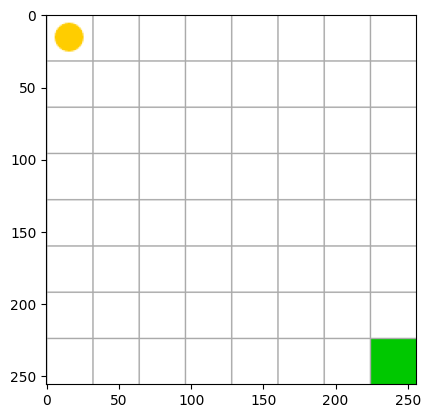

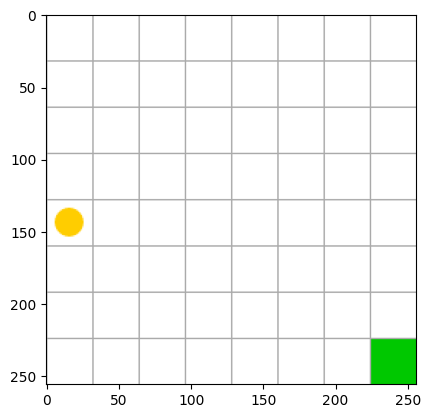

In [204]:
ENV_NAME = CustomEnv.Grid_2D_8x8_discrete

OBSTACLE = ObstacleTypes.obst_free_8x8
INITIAL_STATE_POLICY_I = (0,0)
INITIAL_STATE_POLICY_II = (4,0)
FINAL_STATE = (7, 7)

env_2D_grid_initial_config_I = Grid2DInitialConfig(
    obstacles=OBSTACLE,
    initial_state=INITIAL_STATE_POLICY_I,
    target_state=FINAL_STATE,
)

env_2D_grid_initial_config_II = Grid2DInitialConfig(
    obstacles=OBSTACLE,
    initial_state=INITIAL_STATE_POLICY_II,
    target_state=FINAL_STATE,
)


env = InitialConfigCustom2DGridEnvWrapper(gym.make(ENV_NAME, render_mode=render_mode),
                                          env_config=env_2D_grid_initial_config_I)
snapshot_env(env)

env.set_starting_point(INITIAL_STATE_POLICY_II)

snapshot_env(env)

**configure behavioral policies**

In [200]:
IDENTIFIER_COMBINED_DATASETS = "_stiching_property_I"

# Dataset I
BEHAVIOR_POLICY_I = BehaviorPolicyType.behavior_8x8_moves_downwards_within_strip
DATA_SET_IDENTIFIER_I = "_move_downwards"
NUM_STEPS_I = 20000

# Dataset II
#BEHAVIOR_POLICY_II = BehaviorPolicyType.behavior_8x8_eps_greedy_4_0_to_7_7
BEHAVIOR_POLICY_II = BehaviorPolicyType.behavior_8x8_deterministic_4_0_to_7_7
DATA_SET_IDENTIFIER_II = "_move_deterministic"
NUM_STEPS_II = 1000

In [201]:
select_policy_to_render = widget_list([BEHAVIOR_POLICY_I, BEHAVIOR_POLICY_II])

Dropdown(options=(<BehaviorPolicyType.behavior_8x8_moves_downwards_within_strip: 'behavior_8x8_moves_downwards…

In [203]:
offpolicy_rendering(
    env_or_env_name=ENV_NAME,
    render_mode=render_mode,
    behavior_policy_name=select_policy_to_render.value,
    env_2d_grid_initial_config=env_2D_grid_initial_config,
    num_frames=1000,
)

SystemExit: 

**Create datasets**

In [206]:
config_combined_data = create_combined_minari_dataset(
        env_name=ENV_NAME,
        dataset_identifiers = (DATA_SET_IDENTIFIER_I, DATA_SET_IDENTIFIER_II),
        num_collected_points = (NUM_STEPS_I, NUM_STEPS_II),
        behavior_policy_names = (BEHAVIOR_POLICY_I, BEHAVIOR_POLICY_II),
        combined_dataset_identifier = "combined_dataset",
        env_2d_grid_initial_config = (env_2D_grid_initial_config_I, env_2D_grid_initial_config_II),
)
buffer_data = load_buffer_minari(config_combined_data.data_set_name)
data_size = len(buffer_data)

dataset_availables = [config_combined_data.data_set_name] + config_combined_data.children_dataset_names
selected_data_set = widget_list(dataset_availables)

Dataset Grid_2D_8x8_discrete-data_obst_free_8x8_start_0_0_target_7_7_move_downwards-v0 deleted!
Dataset Grid_2D_8x8_discrete-data_obst_free_8x8_start_4_0_target_7_7_move_deterministic-v0 deleted!
Dataset Grid_2D_8x8_discrete-combined_dataset-v0 deleted!
Number of episodes in dataset I:334, in dataset II:100 and  in the combined dataset: 434
Dataset /home/ivan/Documents/GIT_PROJECTS/tfl-training-rl/src/training_rl/offline_rl/data/offline_data/Grid_2D_8x8_discrete-combined_dataset-v0 downloaded. number of episodes: 434


Dropdown(options=('Grid_2D_8x8_discrete-combined_dataset-v0', 'Grid_2D_8x8_discrete-data_obst_free_8x8_start_0…

Dataset /home/ivan/Documents/GIT_PROJECTS/tfl-training-rl/src/training_rl/offline_rl/data/offline_data/Grid_2D_8x8_discrete-data_obst_free_8x8_start_0_0_target_7_7_move_downwards-v0 downloaded. number of episodes: 334


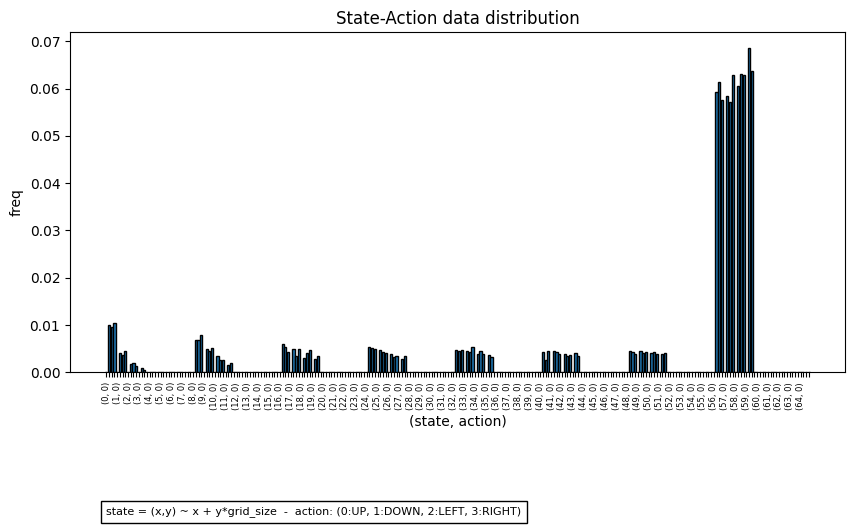

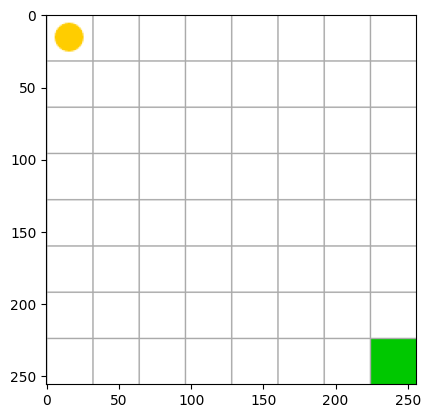

In [212]:
buffer_data = load_buffer_minari(selected_data_set.value)
len_buffer = len(buffer_data)

# Compute state-action data distribution
state_action_count_data, _ = get_state_action_data_and_policy_grid_distributions(buffer_data, env)
state_action_histogram(state_action_count_data, title="State-Action data distribution", inset_pos_xy=(-0.1, -0.03))

if "start_0_0" in selected_data_set.value:
    env.set_starting_point((0,0))
    snapshot_env(env)
elif "start_4_0" in selected_data_set.value:
    env.set_starting_point((4,0))
    snapshot_env(env)
    

### Training and analysis of results

In [186]:
offline_rl_policies = [PolicyName.bcq_discrete, PolicyName.cql_discrete, PolicyName.imitation_learning]
selected_offline_rl_policy = widget_list(offline_rl_policies)

Dropdown(options=(<PolicyName.bcq_discrete: 'bcq_discrete'>, <PolicyName.cql_discrete: 'cql_discrete'>, <Polic…

In [ ]:
# Offiline - Training

NUM_EPOCHS =10
BATCH_SIZE = 128
STEP_PER_EPOCH = 1.0*len_buffer
NUMBER_TEST_ENVS = 1


offline_policy_config = TrainedPolicyConfig(
    name_expert_data=selected_data_set.value,
    policy_name=selected_offline_rl_policy.value,
    render_mode=render_mode,
    device="cpu"
)

#offline_policy_config.policy_config["unlikely_action_threshold"]=0.6
#offline_policy_config.policy_config["min_q_weight"]=15.0
#offline_policy_config.policy_config["num_quantiles"]=5

offline_training(
    offline_policy_config=offline_policy_config,
    num_epochs = NUM_EPOCHS,
    number_test_envs=NUMBER_TEST_ENVS,
    step_per_epoch=STEP_PER_EPOCH,
    restore_training=False,
)

**Restore and visualize trained policy**

In [188]:
available_obstacles = [ObstacleTypes.obstacle_8x8_top_right, ObstacleTypes.obst_free_8x8]
selected_obstacle = widget_list(available_obstacles)

Dropdown(options=(<ObstacleTypes.obstacle_8x8_top_right: ['00000100', '00000100', '00000111', '00000000', '000…

In [ ]:
SAVED_POLICY_NAME = "policy.pth"
INITIAL_STATE = (3, 0)
FINAL_STATE = (0, 7)

offline_policy_config = TrainedPolicyConfig(
    name_expert_data=selected_data_set.value,
    policy_name=selected_offline_rl_policy.value,
    render_mode=render_mode,
    device="cpu"
)

policy = restore_trained_offline_policy(offline_policy_config)
log_name = os.path.join(selected_data_set.value, selected_offline_rl_policy.value)
log_path = get_trained_policy_path(log_name)
policy.load_state_dict(torch.load(os.path.join(log_path, SAVED_POLICY_NAME), map_location="cpu"))

env.set_new_obstacle_map(selected_obstacle.value.value)
env.set_starting_point(INITIAL_STATE)
env.set_goal_point(FINAL_STATE)
#snapshot_env(env)

offpolicy_rendering(
    env_or_env_name=env,
    render_mode=render_mode,
    policy_model=policy,
    env_2d_grid_initial_config=env_2D_grid_initial_config,
    num_frames=1000,
    imitation_policy_sampling=False
)

**What do you observe? Try to increase the number of expert samples and run it again? What happens now?**

**As we can see the BCQ algorithm is able to stitch two trajectories in order to create an optimal one.**

**Try to do the same with CQL and compare results.**

## Exercise III

1 - Add an obstacle around the target. The same as in notebook-161.

2 - To modify BCQ parameters, please refer to **'offline_policy_config.policy_config'** and adjust the **'unlikely_action_threshold'**, which controls the distributional shift. This parameter ranges from 0 (conservative) to 1 (non-conservative). Experiment to find a value that ensures the agent remains within the desired distribution when obstacles are removed around the target

3 - Repeat everything for the CQL algorithm.

## Exercise IV

**In this exercise, we'll evaluate the distributional shift in the CQL and BCQ algorithms and how they deal with it.**

As mentioned earlier, regularization methods such as CQL are a suitable choice when prioritizing safety in your agent's behavior. However, if your focus is primarily on achieving an optimal solution with fewer constraints on safety, methods like BCQ may be more suitable.

In this exercise we will start from (0,0) and we will try to reach the target at (4,7) but the target is protected by a wall. We will collect data again from suboptimal policies as shown below (section 1.2).

### Environment

In [ ]:
ENV_NAME = CustomEnv.Grid_2D_8x8_discrete

# Env. Config.
OBSTACLE = ObstacleTypes.door_object_8x8
INITIAL_STATE = (0, 0)
FINAL_STATE = (4, 7)

env_2D_grid_initial_config = Grid2DInitialConfig(
    obstacles=OBSTACLE,
    initial_state=INITIAL_STATE,
    target_state=FINAL_STATE,
)

env = InitialConfigCustom2DGridEnvWrapper(gym.make(ENV_NAME, render_mode=render_mode),
                                          env_config=env_2D_grid_initial_config)
snapshot_env(env)

### Configure the two datasets

In [ ]:
IDENTIFIER_COMBINED_DATASETS = "_conservative_test"

# Dataset I
#BEHAVIOR_POLICY_I = BehaviorPolicyType.behavior_8x8_moves_downwards_within_strip
BEHAVIOR_POLICY_I = BehaviorPolicyType.behavior_8x8_grid_suboptimal_0_0_to_4_7
DATA_SET_IDENTIFIER_I = "_suboptimal"
NUM_STEPS_I = 500

# Dataset II
#BEHAVIOR_POLICY_II = BehaviorPolicyType.behavior_8x8_eps_greedy_4_0_to_7_7
BEHAVIOR_POLICY_II = BehaviorPolicyType.random#behavior_8x8_grid_deterministic_0_0_to_4_7
DATA_SET_IDENTIFIER_II = "_random"
NUM_STEPS_II = 8000

### Create Minari combined dataset

In [ ]:
config_combined_data = create_combined_minari_dataset(
        env_name=ENV_NAME,
        dataset_identifiers = (DATA_SET_IDENTIFIER_I, DATA_SET_IDENTIFIER_II),
        num_collected_points = (NUM_STEPS_I, NUM_STEPS_II),
        behavior_policy_names = (BEHAVIOR_POLICY_I, BEHAVIOR_POLICY_II),
        combined_dataset_identifier = "combined_dataset",
        env_2d_grid_initial_config = env_2D_grid_initial_config,
)
buffer_data = load_buffer_minari(config_combined_data.data_set_name)
data_size = len(buffer_data)

### Rendering behavioral policy

In [ ]:
# Policy I
offpolicy_rendering(
    env_or_env_name=ENV_NAME,
    render_mode=render_mode,
    behavior_policy_name=BEHAVIOR_POLICY_I,
    env_2d_grid_initial_config=env_2D_grid_initial_config,
    num_frames=1000,
)

### Choose your policy

In [ ]:
# The model policy to be trained.
POLICY_NAME = PolicyName.bcq_discrete


NAME_EXPERT_DATA = config_combined_data.data_set_name
# TrainedPolicyConfig is a handy object that will help us to deal with the policy configuration data.
offline_policy_config = TrainedPolicyConfig(
    name_expert_data=NAME_EXPERT_DATA,
    policy_name=POLICY_NAME,
    render_mode=render_mode,
    device="cpu",
)

### Training

In [ ]:
NUM_EPOCHS = 20
BATCH_SIZE = 128
STEP_PER_EPOCH = 0.1*data_size

# After every epoch we will collect some test statistics from the policy from NUMBER_TEST_ENVS independent envs.
NUMBER_TEST_ENVS = 1
EXPLORATION_NOISE = True
SEED = None #1626


# Run the training
offline_training(
    offline_policy_config=offline_policy_config,
    num_epochs = NUM_EPOCHS,
    number_test_envs=NUMBER_TEST_ENVS,
    step_per_epoch=STEP_PER_EPOCH,
    restore_training=False,
)

### Restore policy

In [ ]:
POLICY_FILE = "policy_best_reward.pth"
# restore a policy with the same configuration as the one we trained.
policy = restore_trained_offline_policy(offline_policy_config)
# load the weights
name_expert_data = offline_policy_config.name_expert_data
log_name = os.path.join(name_expert_data, POLICY_NAME)
log_path = get_trained_policy_path(log_name)
policy.load_state_dict(torch.load(os.path.join(log_path, POLICY_FILE), map_location="cpu"))

### Render trained policy

In [ ]:
offpolicy_rendering(
    env_or_env_name=env,
    render_mode=render_mode,
    policy_model=policy,
    env_2d_grid_initial_config=env_2D_grid_initial_config,
    num_frames=1000,
    imitation_policy_sampling=False
)

## Exercise V

a) Remove the obstacle. What do you think are going to be the results?

b) Modify the parameters related to distributional shift in BCQ and CQL, and observe their impact on out-of-distribution behavior.

## ToDo: Extra exercises --> 1 - Robotic hand  ; 2 - TORCS with suboptimal data or an example that cannot be tackle by BC?? -> This is also related with stiching 

## Final remarks

Offline RL proves valuable in various scenarios, especially when:

a. Robots require intelligent behavior in complex open-world environments demanding extensive training data due to robust visual perception requirements. (complex environment modeling and extensive data collection)

b. Robot grasping tasks, which involve expert data that cannot be accurately simulated, providing an opportunity to assess our BCQ algorithm.

c. Robotic navigation tasks, where offline RL aids in crafting effective navigation policies using real-world data.

d. Autonomous driving, where ample expert data and an offline approach enhance safety.

e. Healthcare applications, where safety is paramount due to the potential serious consequences of inaccurate forecasts.

... and many more.

However, if you have access to an environment with abundant data, online Reinforcement Learning (RL) can be a powerful choice due to its potential for exploration and real-time feedback. Nevertheless, the landscape of RL is evolving, and a data-centric approach is gaining prominence, exemplified by vast datasets like X-Embodiment. It's becoming evident that robots trained with diverse data across various scenarios tend to outperform those solely focused on specific tasks. Furthermore, leveraging multitask trained agents for transfer learning can be a valuable strategy for addressing your specific task at hand.

In [ ]:
# Policy II
offpolicy_rendering(
    env_or_env_name=ENV_NAME,
    render_mode=render_mode,
    behavior_policy_name=BEHAVIOR_POLICY_II,
    env_2d_grid_initial_config=env_2D_grid_initial_config,
    num_frames=1000,
)